**Exploratory Text Analytics**

**Final Project**

**Marin Lolic (ejz2sg)**

In [174]:
import os
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.stem.porter import PorterStemmer

from numpy.linalg import norm
from scipy.spatial.distance import pdist

import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import seaborn as sns
sns.set(style="ticks")

import plotly_express as px

from scipy.linalg import eigh as eig

from tqdm import tqdm
import re

from gensim.models import word2vec
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /home/ejz2sg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ejz2sg/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


------------------------------------------------------------------------------------------------------
*Importing Files*

------------------------------------------------------------------------------------------------------

In [4]:
os.chdir('/sfs/qumulo/qhome/ejz2sg/ds5110/ETA/Project')
epub_file = "Shakespeare.txt"
epub = open(epub_file, 'r', encoding='utf-8-sig').readlines()
shakespeare = pd.DataFrame(epub, columns=['line_str'])

In [5]:
sonnets = shakespeare[84:2852]
sonnets.columns = ['line_str']
sonnets.index.name = 'line_num'

In [6]:
sonnets.head(10)

,line_str
line_num,
84,1\n
85,\n
86,"From fairest creatures we desire increase,\n"
87,"That thereby beauty’s rose might never die,\n"
88,"But as the riper should by time decease,\n"
89,His tender heir might bear his memory:\n
90,"But thou contracted to thine own bright eyes,\n"
91,Feed’st thy light’s flame with self-substantia...
92,"Making a famine where abundance lies,\n"


In [7]:
libdata = {'book_id': [1],
        'book_title': ['The Sonnets'],
       'book_file': ['Shakespeare.txt'],
       'author': ['Shakespeare'],
       'title': ['Sonnets']}

LIB = pd.DataFrame(libdata)

In [8]:
LIB

,book_id,book_title,book_file,author,title
0,1,The Sonnets,Shakespeare.txt,Shakespeare,Sonnets


------------------------------------------------------------------------------------------------------
*Cleaning and Preprocessing Data*

------------------------------------------------------------------------------------------------------

In [9]:
OHCO = ['poem_num', 'line_num', 'token_num']

In [10]:
sonnets['title'] = LIB.book_title[0]

In [11]:
sonnets['line_str'] = sonnets['line_str'].str.rstrip('\n')

In [12]:
sonnets['line_str'] = sonnets['line_str'].str.strip()

In [13]:
breaks = list(range(1, 155))
breaks_str = list(map(str, breaks))

In [14]:
line_start = []

for i in range(0, 154):
    a = sonnets[sonnets['line_str'] == breaks_str[i]].index[0]
    line_start.append(a)

In [15]:
line_end = line_start.copy()
del line_end[0]
line_end = [x - 1 for x in line_end]
line_end.append(sonnets.last_valid_index())

In [16]:
sonnets_p = sonnets.drop('title', axis=1)

In [17]:
sonnets_p['line_str'] = sonnets_p['line_str'].str.replace(',', '')
sonnets_p['line_str'] = sonnets_p['line_str'].str.replace(':', '')
sonnets_p['line_str'] = sonnets_p['line_str'].str.replace(';', '')
sonnets_p['line_str'] = sonnets_p['line_str'].str.replace('.', '')

In [18]:
lookup = pd.DataFrame({'start': line_start, 'end': line_end, 'poem': breaks})

In [19]:
poems_l = []

for i in range(0, len(sonnets_p)):
    target = sonnets_p.index[i]
    answ = lookup[lookup['end'].ge(target)].index[0]+1
    poems_l.append(answ)

In [20]:
sonnets_p = pd.DataFrame({OHCO[0]: poems_l, OHCO[1]: list(sonnets_p.index),
                          'line_str': sonnets_p['line_str']})

sonnets_p = sonnets_p.set_index(['poem_num', 'line_num'])

In [21]:
sonnets_p['line_str'].replace('', np.nan, inplace=True)
sonnets_p.dropna(subset=['line_str'], inplace=True)

In [22]:
sonnets_t = sonnets_p['line_str'].str.split(r"[\s',-]+", expand=True).stack()\
    .to_frame().rename(columns={0:'token_str'})

In [23]:
sonnets_t.index.names = OHCO[0:3]
sonnets_t.reset_index(inplace = True, level = 'token_num')
sonnets_t['token_num'] = list(range(0, len(sonnets_t)))
sonnets_t.reset_index(inplace = True)
sonnets_t = sonnets_t.set_index(OHCO[0:3])

In [24]:
sonnets_t['pos_tup'] = nltk.pos_tag(sonnets_t['token_str'])
sonnets_t['pos'] = sonnets_t.pos_tup.apply(lambda x: x[1])

In [25]:
TOKEN = sonnets_t.copy()

In [26]:
TOKEN['term_str'] = TOKEN['token_str'].str.lower().str.replace('[\W_]', '')

In [27]:
VOCAB = TOKEN.term_str.value_counts().to_frame().rename(columns={'index':'term_str', 'term_str':'n'})\
    .sort_index().reset_index().rename(columns={'index':'term_str'})
VOCAB.index.name = 'term_id'
VOCAB['num'] = VOCAB.term_str.str.match("\d+").astype('int')

In [28]:
TOKEN['term_id'] = TOKEN.term_str.map(VOCAB.reset_index().set_index('term_str').term_id)

In [29]:
TOKEN

token_str           pos_tup  pos   term_str  \
poem_num line_num token_num                                                
1        84       0                  1           (1, CD)   CD          1   
         86       1               From        (From, IN)   IN       from   
                  2            fairest     (fairest, JJ)   JJ    fairest   
                  3          creatures  (creatures, NNS)  NNS  creatures   
                  4                 we         (we, PRP)  PRP         we   
...                                ...               ...  ...        ...   
154      2851     17770           this        (this, DT)   DT       this   
                  17771             by          (by, IN)   IN         by   
                  17772           that        (that, DT)   DT       that   
                  17773              I          (I, PRP)  PRP          i   
                  17774          prove      (prove, VBP)  VBP      prove   

                             term_id  
poem_num line_num token_num           
1        84       0                0  
         86       1             1244  
                  2             1071  
                  3              716  
                  4             3116  
...                              ...  
154      2851     17770         2848  
                  17771          535  
                  17772         2818  
                  17773         1499  
                  17774         2199  

[17775 rows x 5 columns]

In [30]:
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

In [31]:
VOCAB['stop'] = VOCAB.term_str.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

In [32]:
stemmer = PorterStemmer()
VOCAB['p_stem'] = VOCAB.term_str.apply(stemmer.stem)

In [33]:
if 'term_rank' not in VOCAB.columns:
    VOCAB = VOCAB.sort_values('n', ascending=False).reset_index()
    VOCAB.index.name = 'term_rank'
    VOCAB = VOCAB.reset_index()
    VOCAB = VOCAB.set_index('term_id')
    VOCAB['term_rank'] = VOCAB['term_rank'] + 1

In [34]:
bag = OHCO[:1]

In [35]:
BOW = TOKEN.groupby(bag+['term_id']).term_id.count()\
    .to_frame().rename(columns={'term_id':'n'})

BOW['c'] = BOW.n.astype('bool').astype('int')

In [36]:
count_method = 'n'

In [37]:
DTCM = BOW[count_method].unstack().fillna(0).astype('int')

In [38]:
tf_method = 'sum' 
tf_norm_k = .5 

if tf_method == 'sum':
    TF = DTCM.T / DTCM.T.sum()
elif tf_method == 'max':
    TF = DTCM.T / DTCM.T.max()
elif tf_method == 'log':
    TF = np.log10(1 + DTCM.T)
elif tf_method == 'raw':
    TF = DTCM.T
elif tf_method == 'double_norm':
    TF = DTCM.T / DTCM.T.max()
    TF = tf_norm_k + (1 - tf_norm_k) * TF[TF > 0]
elif tf_method == 'binary':
    TF = DTCM.T.astype('bool').astype('int')
TF = TF.T

In [39]:
DF = DTCM[DTCM > 0].count()

In [40]:
N = DTCM.shape[0]

idf_method = 'standard'

if idf_method == 'standard':
    IDF = np.log10(N / DF)
elif idf_method == 'max':
    IDF = np.log10(DF.max() / DF)
elif idf_method == 'smooth':
    IDF = np.log10((1 + N) / (1 + DF)) + 1

In [41]:
TFIDF = TF * IDF

In [42]:
TFIDF.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,3281,3282,3283,3284,3285,3286,3287,3288,3289,3290
poem_num,,,,,,,,,,,,,,,,,,,,,
1,0.020444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018697,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [43]:
VOCAB['tfidf_mean'] = TFIDF[TFIDF > 0].mean().fillna(0) 
VOCAB['tfidf_sum'] = TFIDF.sum()
VOCAB['tfidf_median'] = TFIDF[TFIDF > 0].median().fillna(0)
VOCAB['tfidf_max'] = TFIDF.max()

In [44]:
VOCAB

,term_rank,term_str,n,num,stop,p_stem,tfidf_mean,tfidf_sum,tfidf_median,tfidf_max
term_id,,,,,,,,,,
255,1,and,490,0,1,and,0.000498,0.073724,0.000456,0.001876
2820,2,the,430,0,1,the,0.001680,0.225142,0.001569,0.004096
2889,3,to,414,0,1,to,0.000570,0.083260,0.000587,0.001967
1889,4,my,392,0,1,my,0.003277,0.386731,0.002915,0.010234
1963,5,of,370,0,1,of,0.001446,0.193792,0.001312,0.005443
...,...,...,...,...,...,...,...,...,...,...
1282,3287,gently,1,0,0,gentli,0.019531,0.019531,0.019531,0.019531
1283,3288,get,1,0,0,get,0.021034,0.021034,0.021034,0.021034
1284,3289,ghastly,1,0,0,ghastli,0.019359,0.019359,0.019359,0.019359


In [45]:
LIB.to_csv('LIB.csv')
TOKEN.to_csv('TOKEN.csv')
VOCAB.to_csv('VOCAB.csv')

------------------------------------------------------------------------------------------------------
*K-Means Clustering*

------------------------------------------------------------------------------------------------------

In [103]:
L0 = TFIDF.astype('bool').astype('int')
L1 = TFIDF.apply(lambda x: x / x.sum(), 1)
L2 = TFIDF.apply(lambda x: x / norm(x), 1)

In [104]:
DOC = pd.DataFrame({'poem_id': list(range(0,154)), 'title': list(range(0,154))})
DOC.index.name = 'doc_id'

In [105]:
DOC2 = pd.DataFrame({'poem_id': list(range(1,155)), 'title': list(range(1,155))})

In [130]:
n_clusters = 4
DOC2['y_raw'] = KMeans(n_clusters).fit_predict(TFIDF)
DOC2['y_L0'] = KMeans(n_clusters).fit_predict(L0)
DOC2['y_L1'] = KMeans(n_clusters).fit_predict(L1)
DOC2['y_L2'] = KMeans(n_clusters).fit_predict(L2)

In [129]:
DOC2.sort_values('title').style.background_gradient(cmap='viridis')

,poem_id,title,y_raw,y_L0,y_L1,y_L2
0,1,1,0,3,2,1
1,2,2,0,3,2,1
2,3,3,0,3,1,1
3,4,4,0,1,2,1
4,5,5,0,0,2,0
5,6,6,0,1,2,1
6,7,7,0,0,2,1
7,8,8,0,3,1,0
8,9,9,0,3,1,1
9,10,10,0,2,1,2


In [131]:
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([DOC.index.tolist(), DOC.index.tolist()])).reset_index()
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
PAIRS.index.names = ['doc_a', 'doc_b']

In [132]:
PAIRS['euclidean'] = pdist(TFIDF, 'euclidean')

In [143]:
def hca(sims, linkage_method='ward', color_thresh=.3, figsize=(10, 30)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = DOC.title.values
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree,
                                labels=labels,
                                orientation="left",
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

<Figure size 432x288 with 0 Axes>

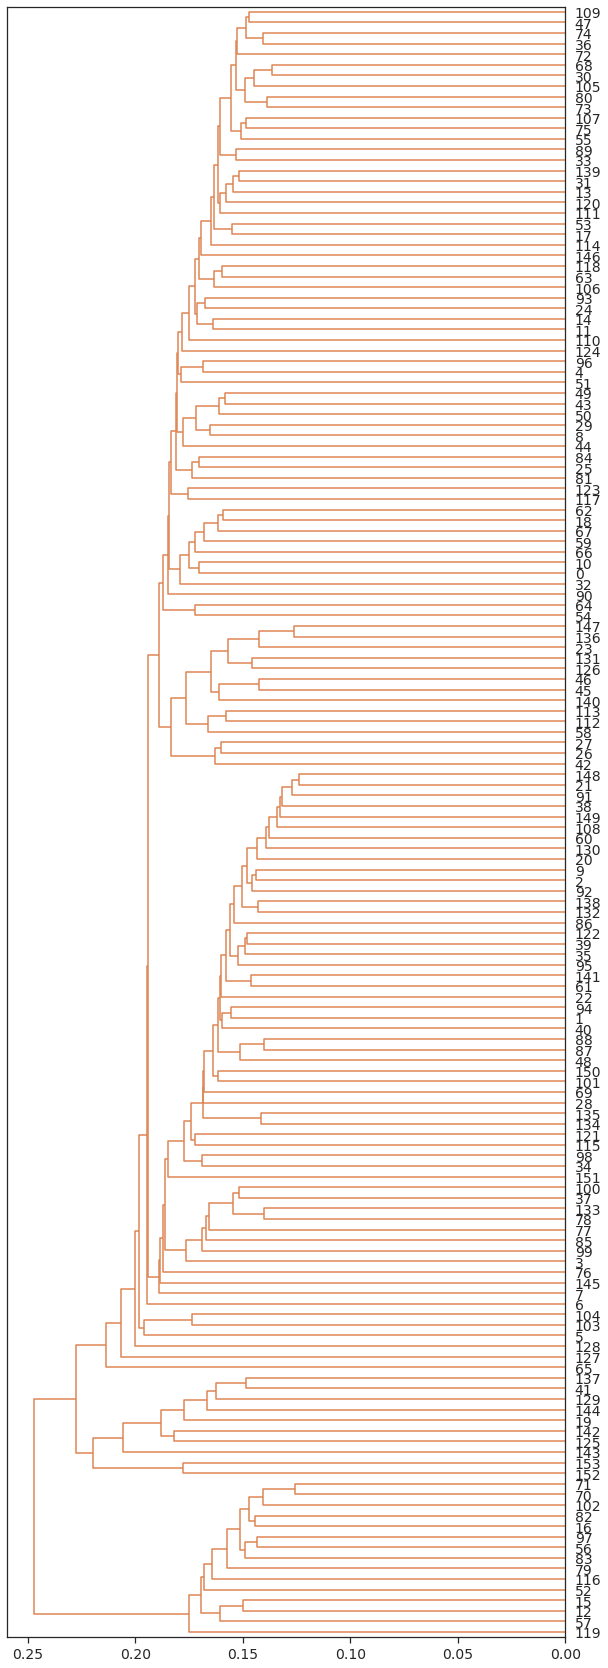

In [144]:
hca(PAIRS.euclidean, color_thresh=1)

------------------------------------------------------------------------------------------------------
*Principal Component Analysis*

------------------------------------------------------------------------------------------------------

In [85]:
TFIDF_2 = TFIDF.apply(lambda x: x / norm(x), 1)
TFIDF_2 = TFIDF_2 - TFIDF_2.mean()
COV = TFIDF_2.cov()

In [86]:
eig_vals, eig_vecs = eig(COV)
TERM_IDX = COV.index

In [145]:
EIG_VEC = pd.DataFrame(eig_vecs, index=TERM_IDX, columns=TERM_IDX)

In [146]:
EIG_VAL = pd.DataFrame(eig_vals, index=TERM_IDX, columns=['eig_val'])
EIG_VAL.index.name = 'term_id'

In [147]:
EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)

In [148]:
EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)

<AxesSubplot:xlabel='term_id'>

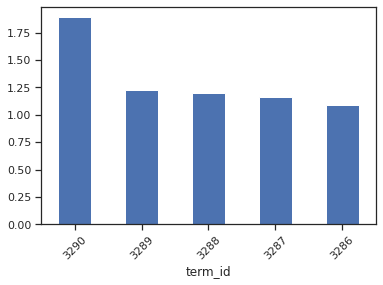

In [149]:
EIG_PAIRS.exp_var.sort_values(ascending=False).head().plot.bar(rot=45)

In [150]:
VOCAB.loc[[3290, 3289, 3288, 3287, 3286]]['term_str']

term_id
3290      zealous
3289       youths
3288     youthful
3287        youth
3286    yourselfs
Name: term_str, dtype: object

In [151]:
TOPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(10).reset_index(drop=True)
TOPS.index.name = 'comp_id'
TOPS.index = ["PC{}".format(i) for i in TOPS.index.tolist()]

In [152]:
LOADINGS = TOPS[TERM_IDX].T
LOADINGS.index.name = 'term_id'
LOADINGS['term_str'] = LOADINGS.apply(lambda x: VOCAB.loc[int(x.name)].term_str, 1)

In [153]:
lb0_pos = LOADINGS.sort_values('PC0', ascending=True).head(10).term_str.str.cat(sep=' ')
lb0_neg = LOADINGS.sort_values('PC0', ascending=False).head(10).term_str.str.cat(sep=' ')
lb1_pos = LOADINGS.sort_values('PC1', ascending=True).head(10).term_str.str.cat(sep=' ')
lb1_neg = LOADINGS.sort_values('PC1', ascending=False).head(10).term_str.str.cat(sep=' ')

In [154]:
print('PC0+', lb0_pos)
print('PC0-', lb0_neg)
print('PC1+', lb1_pos)
print('PC1-', lb1_neg)

PC0+ thy thou thee her heart she thine art dost thyself
PC0- you your yourself should nor world yours were life shall
PC1+ heart eyes mine eye they thy see hearts what doth
PC1- her she mistress loss both sake red fickle will back


In [165]:
DCM = DTCM.dot(TOPS[TERM_IDX].T)

In [172]:
def vis_pcs(M, a, b, prefix='PC'):
    fig = px.scatter(M, prefix + str(a), prefix + str(b),
                    title="Sonnets by PC Exposure")
    fig.show()

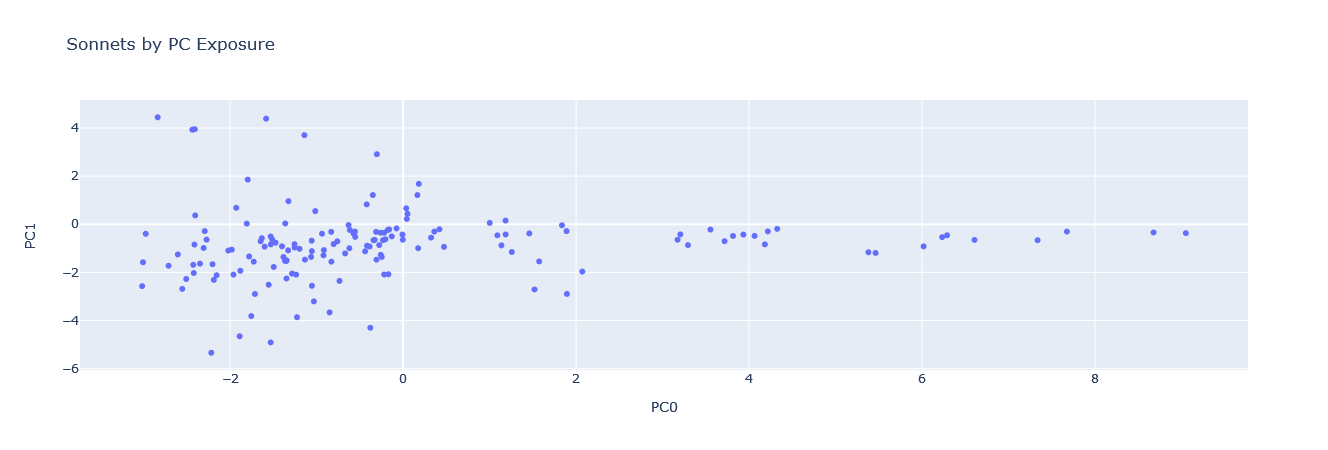

In [173]:
vis_pcs(DCM, 0, 1)

------------------------------------------------------------------------------------------------------
*Latent Dirichlet Allocation*

------------------------------------------------------------------------------------------------------

In [79]:
def init_model():
    
    global n_topics, n_docs, n_words, TOKEN, BOW, TOPIC, THETA, PHI, topic_names

    TOPIC = pd.DataFrame(index=range(n_topics))
    TOPIC.index.name = 'topic_id'
    topic_names = TOPIC.index.tolist()
    
    BOW['topic_id'] = TOPIC.sample(BOW.shape[0], replace=True).index
    
    THETA = BOW.groupby(['topic_id', 'poem_num']).n.sum()\
        .unstack().fillna(0).astype('int')

    PHI = BOW.groupby(['term_id', 'topic_id']).n.sum()\
        .unstack().fillna(0).astype('int')        

    n_docs = THETA.shape[1]
    n_words = PHI.shape[0]

In [80]:
def gibbs_sample(d, w):
    
    global n_topics, n_docs, n_words, BOW, PHI, THETA, alpha, beta, topic_names
    
    z1 = BOW.at[(d, w), 'topic_id']
    n = BOW.at[(d, w), 'n']
    
    PHI.at[w, z1] -= n
    THETA.at[z1, d] -= n

    weights = np.zeros(n_topics)
    for t in topic_names:
        
        P = (PHI.at[w, t] + alpha) / (PHI[t].sum() + n_words * alpha)
        T = (THETA.at[t, d] + beta) / (THETA[d].sum() + n_topics * beta)
        weights[t] = P * T
            
    pwgt = weights / weights.sum()
    z2 = np.random.choice(topic_names, p=pwgt)
     
    PHI.at[w, z2] += n
    THETA.at[z2, d] += n
        
    BOW.at[(d , w), 'topic_id'] = z2

In [88]:
def show_results():
    
    global VOCAB, TOPIC, THETA, PHI, topic_names, docs
        
    P = PHI[topic_names] / PHI[topic_names].sum()
    
    P['term_str'] = VOCAB.term_str 
    for t in topic_names:
        top_terms = P.sort_values(t, ascending=False).head(10)[[t, 'term_str']]
        print('-' * 80)
        print(top_terms)
    
    print('-' * 80)

In [91]:
n_topics = 3
n_iters = 1000
alpha = 0.01
beta = 0.1

In [92]:
init_model()
for i in tqdm(range(n_iters)):
    BOW.apply(lambda x: gibbs_sample(x.name[0], x.name[1]), 1) 

100%|██████████| 1000/1000 [1:49:36<00:00,  6.58s/it]


In [93]:
show_results()

--------------------------------------------------------------------------------
topic_id         0 term_str
term_id                    
2873      0.089030      thy
2852      0.078359     thou
255       0.074692      and
2821      0.054018     thee
1529      0.046349       in
2580      0.024675       so
291       0.017006      art
231       0.016339      all
154       0.015005        a
2840      0.014672    thine
--------------------------------------------------------------------------------
topic_id         1 term_str
term_id                    
255       0.058642      and
1529      0.040344       in
154       0.026235        a
3280      0.024691      you
1457      0.021825      his
3283      0.019621     your
1986      0.017416       or
231       0.015653      all
2580      0.015653       so
2823      0.013889    their
--------------------------------------------------------------------------------
topic_id         2 term_str
term_id                    
2820      0.041992      the
2

------------------------------------------------------------------------------------------------------
*Sentiment Analysis*

------------------------------------------------------------------------------------------------------

In [54]:
salex = pd.read_csv('salex_nrc.csv').set_index('term_str')
salex.columns = [col.replace('nrc_','') for col in salex.columns]
salex['polarity'] = salex.positive - salex.negative

In [55]:
emo_cols = "anger anticipation disgust fear joy sadness surprise trust polarity".split()

In [56]:
TOKENS2 = TOKEN.join(salex, on='term_str', how='left')
TOKENS2[emo_cols] = TOKENS2[emo_cols].fillna(0)

In [57]:
TOKENS2[salex.columns].sample(10)

,,,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,polarity
poem_num,line_num,token_num,,,,,,,,,,,
18,398,1963,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
57,1107,6572,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
1,86,5,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
108,2015,12345,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
12,292,1296,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
1,89,26,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56,1081,6386,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
132,2448,15099,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
14,333,1564,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Sonnets 1-77')

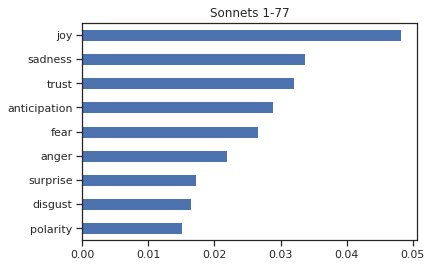

In [73]:
GROUP1 = TOKENS2.loc[1:77].copy()
GROUP1[emo_cols].mean().sort_values().plot.barh().set_title('Sonnets 1-77')

Text(0.5, 1.0, 'Sonnets 87-126')

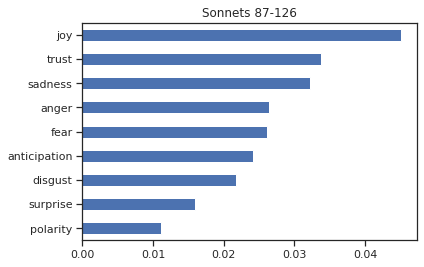

In [74]:
GROUP1_b = TOKENS2.loc[87:126].copy()
GROUP1_b[emo_cols].mean().sort_values().plot.barh().set_title('Sonnets 87-126')

Text(0.5, 1.0, 'Sonnets 78-86')

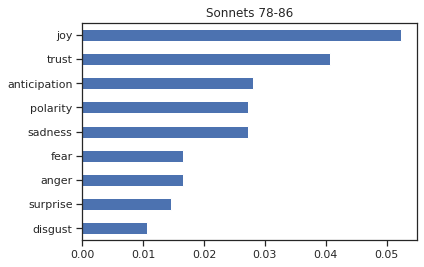

In [64]:
GROUP2 = TOKENS2.loc[78:86].copy()
GROUP2[emo_cols].mean().sort_values().plot.barh().set_title('Sonnets 78-86')

Text(0.5, 1.0, 'Sonnets 127-152')

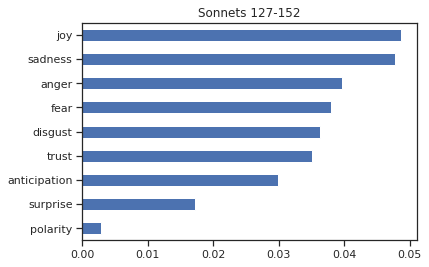

In [66]:
GROUP3 = TOKENS2.loc[127:152].copy()
GROUP3[emo_cols].mean().sort_values().plot.barh().set_title('Sonnets 127-152')

Text(0.5, 1.0, 'Sonnets 153-154')

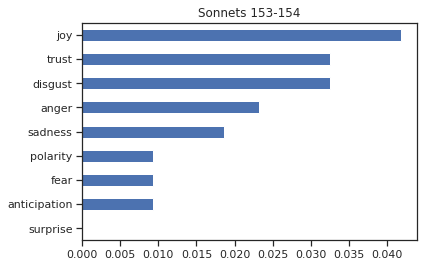

In [67]:
GROUP4 = TOKENS2.loc[153:154].copy()
GROUP4[emo_cols].mean().sort_values().plot.barh().set_title('Sonnets 153-154')

------------------------------------------------------------------------------------------------------
*Vector Embedding*

------------------------------------------------------------------------------------------------------

In [177]:
corpus = TOKEN[~TOKEN.pos.str.match('NNPS?')]\
    .groupby('poem_num')\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()

In [213]:
emb = word2vec.Word2Vec(corpus, vector_size=2, window=5, min_count=200, workers=4)

In [208]:
coords = pd.DataFrame(index=range(len(emb.wv.index_to_key)))
coords['label'] = [w for w in emb.wv.index_to_key]
coords['vector'] = coords['label'].apply(lambda x: emb.wv.get_vector(x))

In [220]:
coords[['X','Y']] = pd.DataFrame(coords.vector.tolist())

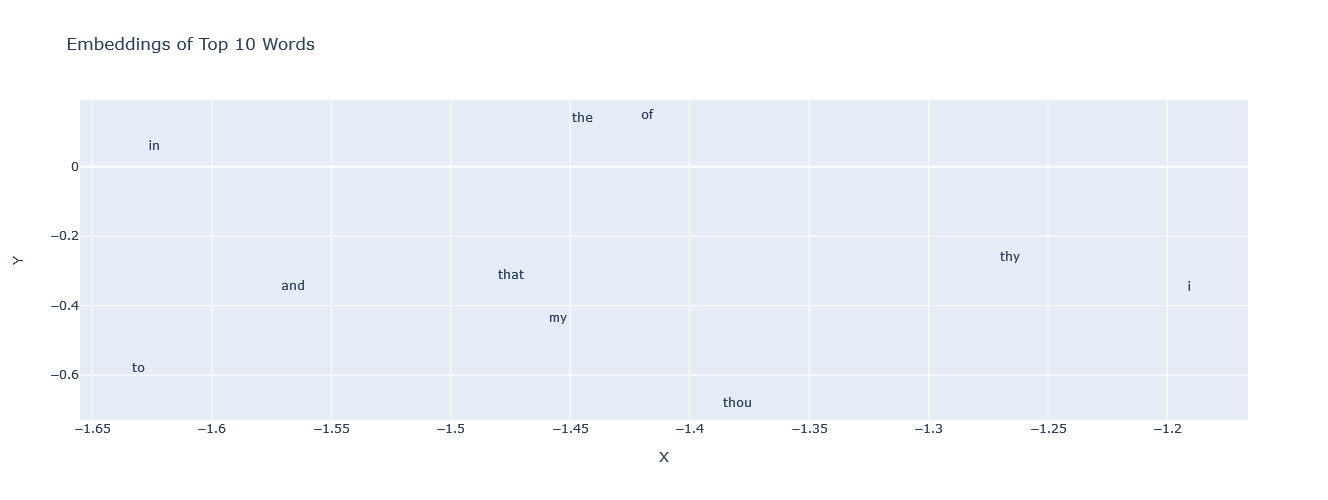

In [227]:
px.scatter(coords, 'X', 'Y', text='label', title = "Embeddings of Top 10 Words",
           height=500, width=500).update_traces(mode='text')